# Import Statements

In [267]:
# Imports and GPU check

import os
import random
import time
from tqdm import tqdm
from itertools import product
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary
import torch
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models

from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.optimize import nnls
from collections import Counter

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Reproducibility

## Seed

In [268]:
def set_seed(seed=7):
    """Sets the seed for reproducibility."""
    # Python RNG
    random.seed(seed)

    # PyTorch RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    # Numpy RNG
    np.random.seed(seed)

    # OS RNG
    os.environ["PYTHONHASHSEED"] = str(seed)


def worker_init_fn(worker_id):
    """Ensure that the data loading process is deterministic."""
    np.random.seed(np.random.get_state()[1][0] + worker_id)


set_seed(7)

# Setting up Dataset

In [269]:
# Hyperparameters
batch_size = 30
dataset_size = 1000  # Reduced dataset size for quicker training

epochs = 10
learning_rate = 0.001

In [270]:
# Import the csv from path.
label_path = "data/pizza_data/imageLabels.txt"
column_path = "data/pizza_data/categories.txt"
image_path = "data/pizza_data/images/"

# Load and prepare the data
df = pd.read_csv(label_path, sep="  ", header=None)
df.columns = open(column_path, "r").read().split("\n")[:-1]

# Add binary column for 'Corn'
df["Corn"] = df["Corn"]  # Create a direct mapping for easier understanding

# Create image path column
df["image_name"] = df.apply(
    lambda x: os.path.join(image_path, str(x.name + 1).zfill(5) + ".jpg"), axis=1
)

# Select only necessary columns
df_binary = df[["Corn", "image_name"]]

# Filter out where 'Corn' is 1; all other labels implicitly 0
df_binary["Corn"] = df["Corn"].apply(lambda x: 1 if x == 1 else 0)

train_df, test_df = train_test_split(
    df_binary, train_size=0.8, shuffle=True, random_state=7
)

C:\Users\20202016\AppData\Local\Temp\ipykernel_21400\3935943164.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(label_path, sep="  ", header=None)
C:\Users\20202016\AppData\Local\Temp\ipykernel_21400\3935943164.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary["Corn"] = df["Corn"].apply(lambda x: 1 if x == 1 else 0)


## Create function to generate image dataset

In [271]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Image path is in the 'image_name' column
        image_name = self.dataframe.iloc[idx]["image_name"]
        image = Image.open(image_name).convert("RGB")

        # Get the binary label for 'Corn'
        label = self.dataframe.iloc[idx]["Corn"]

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label

## Create Balancer

In [272]:
import numpy as np


class BatchSampler:
    def __init__(self, dataset, batch_size, balanced=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.balanced = balanced
        if balanced:
            # Determine indices for each class
            class_0_indices = [i for i, (_, label) in enumerate(dataset) if label == 0]
            class_1_indices = [i for i, (_, label) in enumerate(dataset) if label == 1]

            # Balance by sampling equal amounts from each class
            min_size = min(len(class_0_indices), len(class_1_indices))
            self.indices = np.hstack(
                [
                    np.random.choice(class_0_indices, min_size, replace=False),
                    np.random.choice(class_1_indices, min_size, replace=False),
                ]
            )
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(dataset))

    def __iter__(self):
        # Generate batches
        for start in range(0, len(self.indices), self.batch_size):
            end = start + self.batch_size
            yield self.indices[start:end]

    def __len__(self):
        # Number of batches per epoch
        return (len(self.indices) + self.batch_size - 1) // self.batch_size

# Normalization

## Create trainloaders

In [273]:
# Define transformation (convert to tensor)
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=train_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)


# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

# Create the dataloaders for training and validation
balanced_sampler = BatchSampler(train_dataset, batch_size=batch_size, balanced=True)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_sampler=balanced_sampler,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)


print(
    f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}"
)

Full train set size: 7370 - Reduced train set size: 1000 - Test set size: 1843


In [274]:
train_dataset

In [275]:
def check_balance_in_batches(loader):
    for i, (images, labels) in enumerate(loader):
        if i >= 10:  # Check only the first 5 batches
            break
        print(f"Batch {i + 1} labels:", labels.sum().item(), "out of", len(labels))


check_balance_in_batches(train_loader)

Batch 1 labels: 16 out of 30
Batch 2 labels: 14 out of 30


## Get mean and std

In [276]:
def calculate_mean_and_variance(loader):
    mean = 0.0
    variance = 0.0
    total_images = 0

    for iteration in tqdm(iter(loader)):
        images = iteration[0]
        # Rearrange batch to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total_images
        total_images += images.size(0)
        # Compute mean and variance here
        mean += images.mean(2).sum(0)
        variance += images.var(2).sum(0)

    # Final mean and variance
    mean /= total_images
    variance /= total_images

    return mean, variance


# Assuming train_loader is defined and loaded
mean, variance = calculate_mean_and_variance(train_loader)
std = variance.sqrt()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

Mean: tensor([0.6149, 0.4821, 0.3647])
Standard Deviation: tensor([0.2120, 0.2198, 0.2159])


## Create normalized dataset

In [277]:
transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),  # Normalize images
    ]
)

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=train_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Reducing the dataset size
train_indices = list(range(dataset_size))
test_indices = list(range(200))
train_dataset = Subset(full_train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)

# Create the dataloaders for training and validation
balanced_sampler = BatchSampler(train_dataset, batch_size=batch_size, balanced=True)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_sampler=balanced_sampler,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)


print(
    f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}"
)

Full train set size: 7370 - Reduced train set size: 1000 - Test set size: 200


In [278]:
num_images = 5


def denormalize(img, mean, std):
    """Denormalizes an image to its original form using mean and std"""
    mean = (
        torch.tensor(mean).reshape(-1, 1, 1)
        if not isinstance(mean, torch.Tensor)
        else mean.reshape(-1, 1, 1)
    )
    std = (
        torch.tensor(std).reshape(-1, 1, 1)
        if not isinstance(std, torch.Tensor)
        else std.reshape(-1, 1, 1)
    )
    denorm_img = img * std + mean  # Apply denormalization
    return denorm_img


def imshow(img, mean, std):
    """Shows an image by first denormalizing it"""
    img = denormalize(img, mean, std)  # Denormalize
    img = torch.clamp(img, 0, 255)  # Ensure the image is within [0, 255]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Image Number: {image_number}")
    plt.axis("off")  # Optional: to hide axes for cleaner display
    plt.show()


# Select random images and plot them with labels
classes = ["No Corn", "Corn"]

# num_images = 5
# indices = random.sample(range(len(test_dataset)), num_images)
# for idx in indices:
#     image, label = test_dataset[idx]  # Get image and label from dataset
#     image_name = test_dataset.dataframe.iloc[idx]["image_name"]  # Get image path
#     image_number = (
#         image_name.split("/")[-1].split(".")[0].lstrip("0")
#     )  # Parse the image number from the path
#     if image_number == "":  # Handle the case where the image number might be '00000'
#         image_number = "0"
#     print(f"Label: {classes[label]} - Image Number: {image_name}")
#     imshow(image, mean, std)  # Pass mean and std as tensors

# Model

In [279]:
class Linear_Model(nn.Module):
    def __init__(self):
        super(Linear_Model, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(96, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(512, 1),  # Note the change here for binary classification
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Linear_Model().to(device)
print("Device is " + str(device))

Device is cuda


In [280]:
# Loss function and optimizer for binary classification
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Validation

In [281]:
import torch
import time


def train_and_validate(
    model, train_loader, test_loader, criterion, optimizer, epochs, device
):
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []
    start_time = time.time()

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = (
                images.to(device),
                labels.to(device).float(),
            )  # Convert labels to float for BCEWithLogitsLoss
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(
                outputs.view(-1), labels
            )  # Ensure output and labels dimensions match
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            predicted = (
                torch.sigmoid(outputs.view(-1)) > 0.5
            )  # Apply sigmoid and threshold to determine predictions
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss / total_train)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        validation_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images)
                loss = criterion(outputs.view(-1), labels)

                validation_loss += loss.item() * images.size(0)
                predicted = torch.sigmoid(outputs.view(-1)) > 0.5
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        validation_accuracy = 100 * correct_val / total_val
        validation_losses.append(validation_loss / total_val)
        validation_accuracies.append(validation_accuracy)

        print(
            f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.2f}%, Validation Loss: {validation_losses[-1]:.4f}, Validation Accuracy: {validation_accuracies[-1]:.2f}%"
        )

    end_time = time.time()
    execution_time = end_time - start_time
    minutes = int(execution_time // 60)
    seconds = int(execution_time % 60)
    print(f"\nExecution time: {minutes:02}:{seconds:02}")

    return train_losses, train_accuracies, validation_losses, validation_accuracies

In [282]:
def plot_metrics(
    train_losses, train_accuracies, validation_losses, validation_accuracies
):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.title("Training vs. Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(validation_accuracies, label="Validation Accuracy")
    plt.title("Training vs. Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Results of model with balancer

Epoch [1/10], Training Loss: 0.7553, Training Accuracy: 43.33%, Validation Loss: 0.7840, Validation Accuracy: 3.00%
Epoch [2/10], Training Loss: 0.6711, Training Accuracy: 58.33%, Validation Loss: 0.5645, Validation Accuracy: 97.00%
Epoch [3/10], Training Loss: 0.6743, Training Accuracy: 50.00%, Validation Loss: 0.5760, Validation Accuracy: 97.00%
Epoch [4/10], Training Loss: 0.6633, Training Accuracy: 53.33%, Validation Loss: 0.6201, Validation Accuracy: 93.00%
Epoch [5/10], Training Loss: 0.6465, Training Accuracy: 70.00%, Validation Loss: 0.6355, Validation Accuracy: 81.50%
Epoch [6/10], Training Loss: 0.6229, Training Accuracy: 80.00%, Validation Loss: 0.6195, Validation Accuracy: 79.00%
Epoch [7/10], Training Loss: 0.5945, Training Accuracy: 83.33%, Validation Loss: 0.6217, Validation Accuracy: 75.00%
Epoch [8/10], Training Loss: 0.5594, Training Accuracy: 90.00%, Validation Loss: 0.6434, Validation Accuracy: 65.50%
Epoch [9/10], Training Loss: 0.5166, Training Accuracy: 88.33%, V

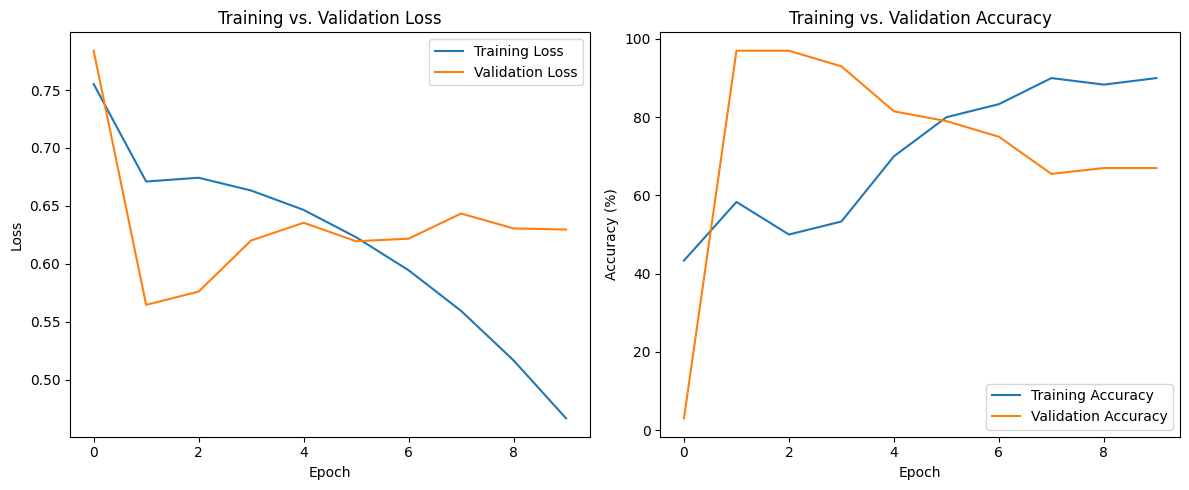

In [283]:
train_losses, train_accuracies, validation_losses, validation_accuracies = (
    train_and_validate(
        model, train_loader, test_loader, criterion, optimizer, 10, device
    )
)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

## Store Binary-class results

In [284]:
def store_metrics_in_dataframe(
    train_losses,
    train_accuracies,
    validation_losses,
    validation_accuracies,
    suffix="",
    dataframe=None,
):
    # If dataframe is not provided, create a new one
    if dataframe is None:
        dataframe = pd.DataFrame()

    # Store the metrics in the dataframe with optional suffixes
    dataframe[f"train_losses_{suffix}"] = train_losses
    dataframe[f"train_accuracies_{suffix}"] = train_accuracies
    dataframe[f"validation_losses_{suffix}"] = validation_losses
    dataframe[f"validation_accuracies_{suffix}"] = validation_accuracies

    return dataframe


metric_df = store_metrics_in_dataframe(
    train_losses,
    train_accuracies,
    validation_losses,
    validation_accuracies,
    suffix="Corn",
    dataframe=metric_df,
)

In [285]:
metric_df

,train_losses_Fresh_basil,train_accuracies_Fresh_basil,validation_losses_Fresh_basil,validation_accuracies_Fresh_basil,train_losses_Pepperoni,train_accuracies_Pepperoni,validation_losses_Pepperoni,validation_accuracies_Pepperoni,train_losses_Tomatoes,train_accuracies_Tomatoes,...,validation_losses_Broccoli,validation_accuracies_Broccoli,train_losses_Pineapple,train_accuracies_Pineapple,validation_losses_Pineapple,validation_accuracies_Pineapple,train_losses_Corn,train_accuracies_Corn,validation_losses_Corn,validation_accuracies_Corn
0,0.701306,53.225806,0.757155,15.5,0.701410,52.439024,0.707403,45.5,0.709654,50.000000,...,0.943953,1.0,0.697390,50.0,0.991176,1.0,0.755252,43.333333,0.784000,3.0
1,0.680550,58.870968,0.754339,30.0,0.646840,61.951220,0.653786,61.0,0.686506,55.198020,...,0.596251,95.5,0.658442,50.0,0.861687,1.0,0.671071,58.333333,0.564536,97.0
2,0.647009,65.725806,0.730705,45.5,0.607818,66.829268,0.621544,70.5,0.671939,61.881188,...,0.557237,95.5,0.604006,70.0,0.763823,24.0,0.674310,50.000000,0.576026,97.0
3,0.606152,68.145161,0.739579,48.0,0.569259,71.707317,0.612776,71.0,0.652767,62.871287,...,0.715846,41.0,0.555501,100.0,0.808061,24.0,0.663293,53.333333,0.620145,93.0
4,0.556651,75.403226,0.830301,45.0,0.529862,75.609756,0.618924,71.5,0.623857,66.089109,...,0.792076,24.0,0.498141,100.0,0.981952,14.0,0.646549,70.000000,0.635455,81.5
5,0.497608,77.016129,0.877611,43.5,0.485681,78.048780,0.634842,69.0,0.592323,69.554455,...,0.641780,63.0,0.434777,100.0,1.119253,14.5,0.622939,80.000000,0.619482,79.0
6,0.418953,83.467742,0.883933,49.0,0.434491,81.219512,0.648958,70.5,0.549372,74.504950,...,0.564502,77.0,0.368692,100.0,1.150316,22.0,0.594461,83.333333,0.621695,75.0
7,0.336306,89.112903,0.835537,53.5,0.373232,85.853659,0.650156,70.0,0.499865,76.237624,...,0.737556,50.5,0.299485,100.0,1.307043,21.5,0.559371,90.000000,0.643410,65.5
8,0.252379,93.548387,0.805483,55.0,0.306525,90.487805,0.656873,72.0,0.443390,80.445545,...,0.766050,48.5,0.231670,100.0,1.678255,17.0,0.516631,88.333333,0.630545,67.0
9,0.173667,97.177419,1.044353,52.5,0.232296,94.878049,0.681175,70.5,0.379970,85.396040,...,0.564830,71.5,0.169196,100.0,1.878291,18.5,0.466572,90.000000,0.629608,67.0


In [286]:
metric_df.to_pickle("binary-metrics.pkl")

C:\Users\20202016\AppData\Local\Temp\ipykernel_21400\601177695.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap("tab20", len(classes))


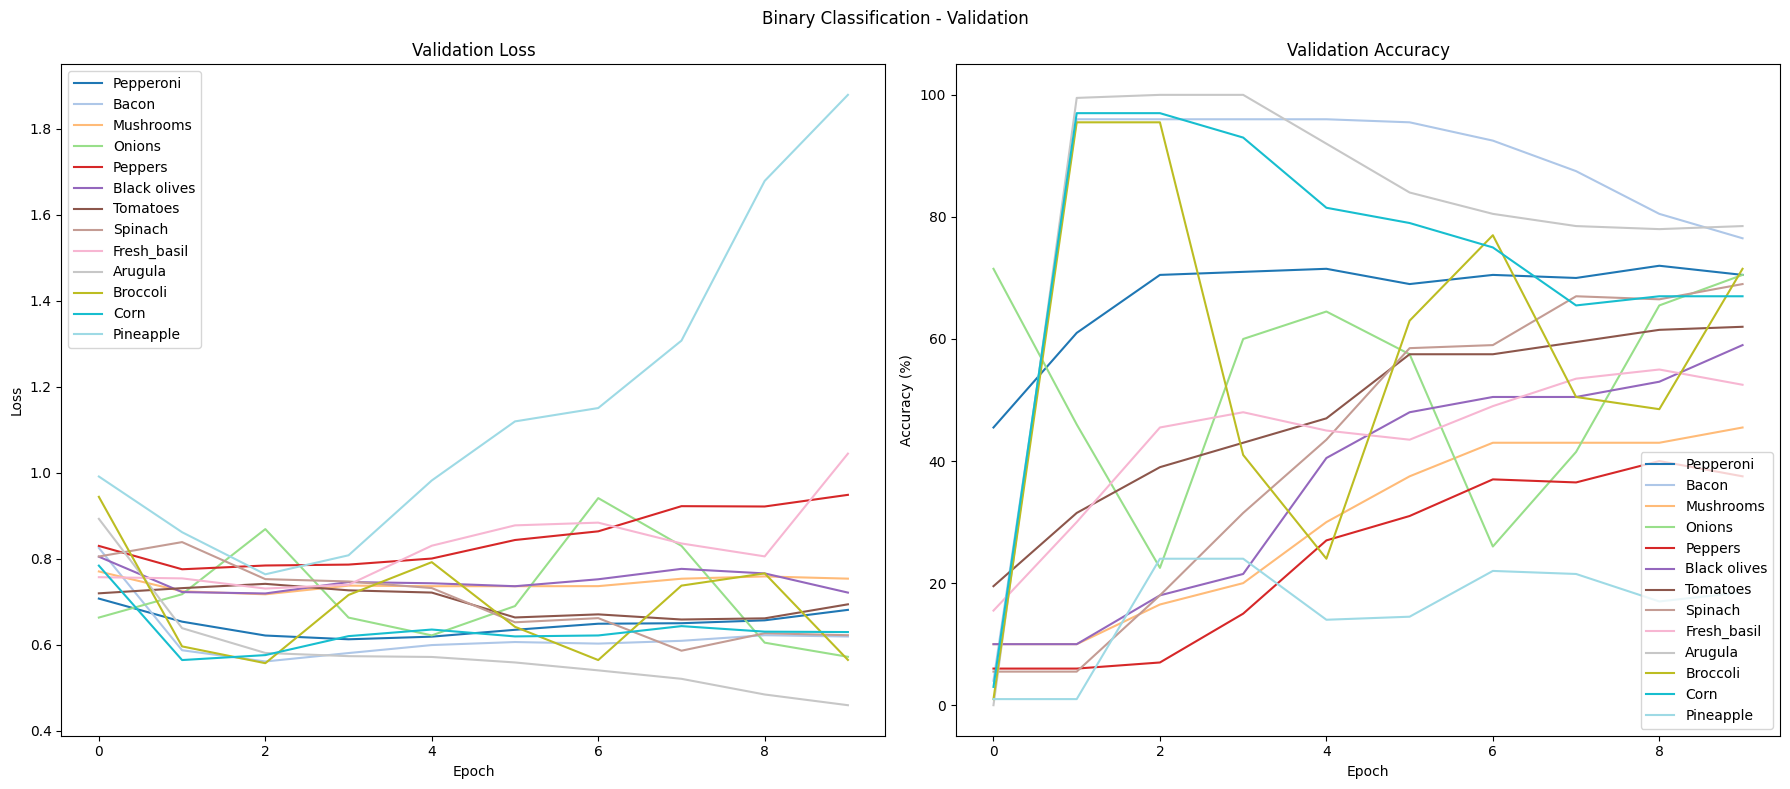

In [309]:
def plot_metrics(dataframe, classes):
    plt.figure(figsize=(18, 8))

    # Define a colormap
    colormap = plt.cm.get_cmap("tab20", len(classes))

    # Plot loss for each class
    plt.subplot(1, 2, 1)
    for i, class_name in enumerate(classes):
        plt.plot(
            dataframe[f"validation_losses_{class_name}"],
            label=f"{class_name}",
            color=colormap(i),
        )
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy for each class
    plt.subplot(1, 2, 2)
    for i, class_name in enumerate(classes):
        plt.plot(
            dataframe[f"validation_accuracies_{class_name}"],
            label=f"{class_name}",
            color=colormap(i),
        )
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.suptitle("Binary Classification - Validation")

    plt.tight_layout()
    plt.show()


labels = [
    "Fresh_basil" if label == "Fresh basil" else label
    for label in list(df.columns[:-1])
]
plot_metrics(metric_df, labels)